In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import datasets

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
train_set, test_set = datasets.load_SVHN()
train_x, train_y = train_set
test_x, test_y = test_set

loading SVHN training images...
loading SVHN test images...


In [ ]:
# def batches(X,y,batch_size=128):
#     assert len(X) == len(y)
#     n = len(X)
#     p = np.random.permutation(n)
    
#     num_batches = n // batch_size
#     for i in range(num_batches):
#         start = i*batch_size
#         end = start+batch_size
#         yield X[p[start:end]], y[p[start:end]]

#     left_over = n % batch_size
#     yield X[p[-left_over:]], y[p[-left_over:]]

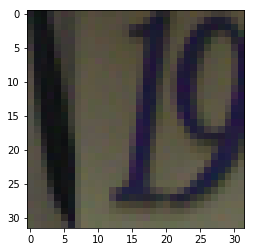

In [3]:
plt.imshow(train_x[0].reshape(32,32,3))

In [22]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

#renaming functions for convinience
dropout = tf.nn.dropout
sigmoid = tf.nn.sigmoid
ReLu = tf.nn.relu
conv = tf.nn.conv2d
deconv = tf.nn.conv2d_transpose
clip = tf.clip_by_value
Adam = tf.train.AdamOptimizer

In [28]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        
        
        
        # tf Graph input
        n_input = network_architecture["n_input"]
        self.x = tf.placeholder(tf.float32, [None, n_input],'x_placeholder')
        
        #Adversarial part of the network
        self.attack = tf.Variable(tf.zeros([n_input], dtype=tf.float32),name='Attack')
        self.adv_x = clip(self.x + self.attack, clip_value_min=0, clip_value_max=1, name='adversarial_x')
        
        n_z = network_architecture["n_z"]
        self.target = tf.placeholder(tf.float32, [None, n_z],'target_z')
        self.C = tf.Variable(1, dtype=tf.float32, trainable=False,name='C')
        
        self.adv_im = tf.reshape(self.adv_x, shape=[-1, 32, 32, 3])
        
        # Create autoencoder network
        self._create_network()
        
        
        self.sess = tf.InteractiveSession()
        
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess.run(init)
    
    def _create_network(self):
        # create keepprob placeholder
        self.keepprob = tf.placeholder(tf.float32,name='keepprob')
        
        # creates autoencode network weights and biases
        weights = self._initialize_weights(**self.network_architecture)
        self.weights = weights
        
        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(weights["weights_recog"], 
                                      weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = self.z_mean + eps*tf.sqrt(tf.exp(self.z_log_sigma_sq))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(weights["weights_gener"],
                                    weights["biases_gener"])
            
    def _initialize_weights(self, n_input, ksize, n1,  n2, n3, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'ce1': tf.Variable(tf.random_normal([ksize, ksize, 3, n1],  stddev=0.1),name='ce1'),
            'ce2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1),name='ce2'),
            'ce3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1),name='ce3'),
            'mean': tf.Variable(xavier_init(n3*4*4, n_z),name='w_mean'),
            'log_sigma': tf.Variable(xavier_init(n3*4*4, n_z),name='w_log_sigma')}
        all_weights['biases_recog'] = {
            'be1': tf.Variable(tf.random_normal([n1], stddev=0.1),name='be1'),
            'be2': tf.Variable(tf.random_normal([n2], stddev=0.1),name='be2'),
            'be3': tf.Variable(tf.random_normal([n3], stddev=0.1),name='be3'),
            'mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32),name='b_mean'),
            'log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32),name='b_log_sigma')}
        
        all_weights['weights_gener'] = {
            'from_z':tf.Variable(xavier_init(n_z,n3*4*4),name='from_z'),
            'cd3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1),name='cd3'),
            'cd2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1),name='cd2'),
            'cd1': tf.Variable(tf.random_normal([ksize, ksize, 3, n1],  stddev=0.1),name='cd1'),}
        all_weights['biases_gener'] = {
            'from_z': tf.Variable(tf.zeros([n3*4*4], dtype=tf.float32),name='b_from_z'),
            'bd3': tf.Variable(tf.random_normal([n2], stddev=0.1),name='bd3'),
            'bd2': tf.Variable(tf.random_normal([n1], stddev=0.1),name='bd2'),
            'bd1': tf.Variable(tf.random_normal([3],  stddev=0.1),name='bd1'),}
        return all_weights
            
    def _recognition_network(self, w, b):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        pad = 'SAME'
        stri = [1, 2, 2, 1]
        
        ce1 = sigmoid( conv(self.adv_im, w['ce1'], strides=stri, padding=pad) + b['be1'] )
        ce1 = dropout( ce1, self.keepprob ) #image size (16,16,n1)
        ce2 = sigmoid( conv(ce1, w['ce2'], strides=stri, padding=pad) + b['be2'] ) 
        ce2 = dropout( ce2, self.keepprob ) #image size (8,8,n2)
        ce3 = sigmoid( conv(ce2, w['ce3'], strides=stri, padding=pad) + b['be3'] )
        ce3 = dropout( ce3, self.keepprob ) #image size (4,4,n3)
        
        n3 = self.network_architecture['n3']
        flat = tf.reshape(ce3, [-1, 4*4*n3])
        
        z_mean = tf.matmul(flat, w['mean']) + b['mean']
        z_log_sigma_sq = tf.matmul(flat, w['log_sigma']) + b['log_sigma']
        
        #valores para debugar
        self._ce1 = ce1
        self._ce2 = ce2
        self._ce3 = ce3
        self._flat = flat
        
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, w, b):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        pad = 'SAME' #padding
        stri = [1,2,2,1] #strides
        n3 = self.network_architecture["n3"]
        n2 = self.network_architecture["n2"]
        n1 = self.network_architecture["n1"]
        n_ex = tf.shape(self.x)[0] #number of examples
        dim3 = tf.stack([n_ex, 8, 8, n2])
        dim2 = tf.stack([n_ex, 16, 16, n1])
        dim1 = tf.stack([n_ex, 32, 32, 3])
        
        from_z = sigmoid(tf.matmul(self.z, w['from_z']) + b['from_z'])
        im_z = tf.reshape(from_z, [-1,4,4,n3],name='im_z')
        
        cd3 = sigmoid(deconv(im_z, w['cd3'], dim3, strides=stri, padding=pad,name='deconv3') +  b['bd3']) 
        cd3 = dropout(cd3, self.keepprob) #image size (8,8,n2)
        cd2 = sigmoid(deconv(cd3, w['cd2'], dim2, strides=stri, padding=pad,name='deconv2') + b['bd2']) 
        cd2 = dropout(cd2, self.keepprob) #image size (16,16,n2)
        cd1 = sigmoid(deconv(cd2, w['cd1'], dim1, strides=stri, padding=pad,name='deconv1') + b['bd1']) 
        #cd1 = dropout(cd1, self.keepprob) #iamge size (32,32,3)
        
        x_reconstr_mean = tf.reshape(cd1, [-1,32*32*3])
        
        #valores para debugar
        self.from_z = from_z
        self.im_z = im_z
        self.cd1 = cd1
        self.cd2 = cd2
        self.cd3 = cd3
        
        return x_reconstr_mean

    def _create_loss_optimizer(self):
        #getting variables that are not form the attack
        all_vars = self.sess.graph.get_collection('trainable_variables')
        w = [var for var in all_vars if 'Attack' not in var.name]
        
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        reconstr_loss = -tf.reduce_sum(
            self.x * tf.log(1e-8 + self.x_reconstr_mean) + (1-self.x) * tf.log(1e-8 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mean) - tf.exp(self.z_log_sigma_sq), 
                                1)
        
        # 3.) The weight loss, (no pun intended), which is a simple
        weight_loss = 0
        for var in w:
            weight_loss += tf.nn.l2_loss(var)
        
        self.B = tf.placeholder(tf.float32,name='B')
        self.G = tf.placeholder(tf.float32,name='G')
        self.cost = tf.reduce_mean(reconstr_loss + self.B*latent_loss)   + self.G*weight_loss# average over batch
        cost = self.cost
        
        self.reconstr_loss = tf.reduce_mean(reconstr_loss)
        self.latent_loss = tf.reduce_mean(latent_loss)
        self.weight_loss = weight_loss
        
        
        # Use ADAM optimizer
        self.optimizer = Adam(learning_rate=self.learning_rate).minimize(cost,var_list=w)
        
        
        self.target_cost = tf.square(self.target - self.z_mean) + self.C*tf.nn.l2_loss(self.attack)
        target_cost = self.target_cost
        
        #Adversarial optimizer
        self.adv_optimizer = Adam(learning_rate=self.learning_rate).minimize(target_cost, var_list=[self.attack])
    
    def reset_attack(self):
        self.sess.run(tf.variables_initializer([self.attack]))
    
    def partial_fit(self, X, keepprob, B, G):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        self.b = B
        self.g = G
        values = self.sess.run((self.optimizer, self.cost, self.reconstr_loss, self.latent_loss, self.weight_loss),
                                  feed_dict={self.x: X, self.keepprob:keepprob,self.B:B,self.G:G})
        
        opt, cost, recon_loss, lat_loss, w_loss = values
        
        return cost, recon_loss, lat_loss, w_loss
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X,self.keepprob:1,self.B:self.b,self.G:self.g})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu,self.keepprob:1,self.B:self.b,self.G:self.g})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X, self.keepprob:1,self.B:self.b,self.G:self.g})

In [103]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    n_samples = len(train_x)
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        avg_recon_loss = 0.
        avg_lat_loss = 0.
        avg_w_loss = 0.
        # Loop over all batches
        for batch_xs, y in datasets.batches(train_x,train_y,batch_size=batch_size):
            if len(batch_xs) != batch_size:
                continue
            # Fit training using batch data
            cost, recon_loss, lat_loss, w_loss = vae.partial_fit(batch_xs, 0.5, 0.01, 0.01)
            
            # Compute average loss
            avg_cost += cost / n_samples * batch_size
            avg_recon_loss += recon_loss / n_samples * batch_size
            avg_lat_loss += lat_loss / n_samples * batch_size
            avg_w_loss += w_loss / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print ("EPOCH: %04d, COST: %.5f, RECONSTR_LOSS: %.5f, LATENT_LOSS: %.5f, WEIGHT_LOSS %.5f" % 
                   (epoch+1, avg_cost, avg_recon_loss, avg_lat_loss, w_loss))
    print ("EPOCH: %04d, COST: %.5f, RECONSTR_LOSS: %.5f, LATENT_LOSS: %.5f, WEIGHT_LOSS %.5f" % 
                   (epoch+1, avg_cost, avg_recon_loss, avg_lat_loss, w_loss))
    return vae

In [104]:
network_architecture = \
    dict(n_input=32*32*3, # SVHN data input (img shape: 32*32*3)
         ksize=5, # Size of filters
         n1=32, # Filters in 1st layer
         n2=64, # Filters in 2nd layer
         n3=128, # Filters in 3rd layer
         n_z=100)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=20)

EPOCH: 0001, COST: 2053.15865, RECONSTR_LOSS: 2019.19568, LATENT_LOSS: 87.43842, WEIGHT_LOSS 940.78204
EPOCH: 0006, COST: 1910.85073, RECONSTR_LOSS: 1900.59088, LATENT_LOSS: 175.72832, WEIGHT_LOSS 859.39752
EPOCH: 0011, COST: 1904.89781, RECONSTR_LOSS: 1893.38015, LATENT_LOSS: 190.25496, WEIGHT_LOSS 971.54047
EPOCH: 0016, COST: 1902.28106, RECONSTR_LOSS: 1890.10463, LATENT_LOSS: 196.68906, WEIGHT_LOSS 1026.85217
EPOCH: 0020, COST: 1901.11492, RECONSTR_LOSS: 1888.66733, LATENT_LOSS: 198.11428, WEIGHT_LOSS 1053.35327


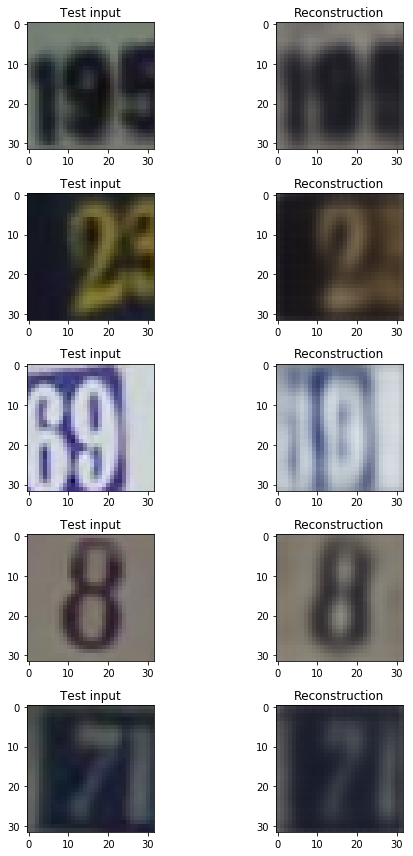

In [106]:
n_ex = len(train_x)
x_sample = train_x[np.random.choice(n_ex,100)]
x_reconstruct = vae.reconstruct(x_sample)
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(32, 32,3), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(32, 32,3), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
plt.tight_layout()

# Adversarial Attack

In [46]:
def plot_images(series=[],titles=[],suptitle='',img_dim = (28,28)):
    num_colums = 3
    num_imgs = len(series)
    num_rows = 2
    
    plt.figure(figsize=(10,5))
    plt.suptitle(suptitle,fontsize=16)
    for i in range(num_imgs):
        plt.subplot(num_rows, num_colums, i+1)
        plt.imshow(series[i].reshape(img_dim),vmin=0,vmax=1,cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

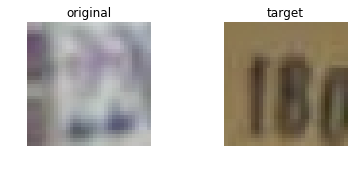

In [47]:
n = len(x_sample)
i_original = np.random.choice(n)
i_target = np.random.choice(n)

original = np.array([x_sample[i_original]])
target = np.array([x_sample[i_target]])

series = [original,target]
titles = ['original','target']
plot_images(series=series,titles=titles, img_dim=(32,32,3))

In [99]:
a = np.array([10000.],np.float32)*a
a

array([  1.00000000e+102])

In [48]:
vae.sess.run(tf.variables_initializer([vae.attack]))
z_target = vae.transform(target)
original_reconstruction = vae.reconstruct(original)[0]
original_target_reconstruction = vae.reconstruct(target)[0]

distance = np.linalg.norm


dist_target_rec_target = distance(target[0]-original_target_reconstruction)
dist_target_rec_original = distance(target[0]-original_reconstruction)
dist_target_original = distance(original_target_reconstruction-original_reconstruction)

vae.sess.run(tf.variables_initializer([vae.attack]))
attack = vae.sess.run(vae.attack)
size_attack = np.linalg.norm(attack)

point = (size_attack,dist_target_rec_original)

points = [point]

feed_dict={vae.x:original,vae.target:z_target,vae.B:0.,vae.G:vae.g}

InvalidArgumentError: Conv2DSlowBackpropInput: input and out_backprop must have the same batch size
	 [[Node: deconv3_7 = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](stack_21, cd3_7/read, im_z_7)]]
	 [[Node: Reshape_23/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_237_Reshape_23", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'deconv3_7', defined at:
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-09b3c570d00b>", line 8, in <module>
    vae = train(network_architecture, training_epochs=200)
  File "<ipython-input-35-60189713dc41>", line 5, in train
    batch_size=batch_size)
  File "<ipython-input-28-78c23d1e9b8b>", line 34, in __init__
    self._create_network()
  File "<ipython-input-28-78c23d1e9b8b>", line 73, in _create_network
    weights["biases_gener"])
  File "<ipython-input-28-78c23d1e9b8b>", line 147, in _generator_network
    cd3 = sigmoid(deconv(im_z, w['cd3'], dim3, strides=stri, padding=pad,name='deconv3') +  b['bd3'])
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1048, in conv2d_transpose
    name=name)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 486, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Conv2DSlowBackpropInput: input and out_backprop must have the same batch size
	 [[Node: deconv3_7 = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](stack_21, cd3_7/read, im_z_7)]]
	 [[Node: Reshape_23/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_237_Reshape_23", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
vae.sess.run(tf.variables_initializer([vae.attack]))
vae.sess.run(tf.assign(vae.C, 0.05))
adv_recon = []
adv_recon.append(original_reconstruction)
points = [point]

titles = ['Original','Target','Original Reconstruction',
          'Adversarial image','Attack','Attacked Reconstruction']
attack_iterations = 0
for i in range(1000):
    vae.sess.run(vae.adversarial_optimizer,feed_dict=feed_dict)
    
    adv_cost = vae.sess.run(vae.target_cost, feed_dict=feed_dict)
    
    reconstruction = vae.reconstruct(original)[0]
    attack = vae.sess.run(vae.attack)
    adversarial_image = vae.sess.run(vae.adversarial_x,feed_dict)
    
    point = (distance(attack),distance(target[0]-reconstruction))
    points.append(point)
    
    adv_recon.append(reconstruction)
    attack_iterations += 1
    
    
    
    if i % 50 == 0:
        series = [original,target,original_reconstruction,
                 adversarial_image,attack,reconstruction]
        suptitle='After %d attack iterations' % attack_iterations
        plot_images(series=series,titles=titles,suptitle=suptitle, img_dim=(32,32,3))
        plt.show()

        print(np.mean(adv_cost))
        

In [ ]:
plt.figure()
plt.axvline(dist_target_original)
plt.axhline(dist_target_rec_target,color='orange')
plt.axhline(dist_target_rec_original,color='green')
x,y=list(zip(*points))
plt.scatter(x,y)

## Gif Maker

ta com algum problema, não sei direito ainda.

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

fig = plt.figure()
im = plt.imshow(adv_recon[0].reshape(32,32,3),animated=True, cmap='gray')
plt.axis('off')

i = 0 
def updatefig(i):
    i += 1
    im.set_array(adv_recon[i*2].reshape(32,32,3))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, blit=True)

In [ ]:
ani

In [ ]:
len(adv_recon)

In [ ]:
fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

In [ ]:
def save_video(vid_file, frames):
    height, width, layers = frames[0].shape

    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    video = cv2.VideoWriter(vid_file, fourcc, 30, (width,height))

    for frame in frames:
        r,g,b = cv2.split(frame)
        bgr_img = cv2.merge([b,g,r])
        #video.write(bgr_img)
        video.write(frame)
    video.release()

In [ ]:
adv_recon = [im.reshape(32,32,3) for im in adv_recon]

In [ ]:
adv_recon = [im.transpose(1,2,0) for im in adv_recon]

In [ ]:
import cv2
file = 'images/test.avi'
save_video(file, adv_recon)

In [ ]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

In [ ]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()